# Install Libraries if Needed (Only Run Once)

In [1]:
# !pip install -U deepxde

# Import Libraries

In [2]:
# Interactive Plotting

# for jupyter notebooks
%matplotlib notebook 

# for jupyter labs
# %matplotlib widget 

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re
import os

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



# Burgers Equation

$$
u_t + u u_x = \frac{0.01}{\pi} u_{xx}, \quad x \in (-1, 1), t \in (0, 0.99],\\
u(x,0) = -\sin(\pi x), \\
u(-1,t) = u(1,t) = 0
$$

# Define Generate Test Data Function

In [17]:
def gen_testdata():
    data = np.load("dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    Nx = len(x)
    Nt = len(t)
    return X, y, Nx, Nt

# Define PDE

In [18]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

# Define Geometry

In [19]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Define ICs/BCs

In [20]:
bc = dde.DirichletBC(geomtime, # geometry
                     lambda x: 0, # value of specified boundary
                     lambda _, on_boundary: on_boundary # check if point is on specified boundary (function of coordinates and boolean on_boundary returns boolean)
                    )
ic = dde.IC(geomtime, # geometry
            lambda x: -np.sin(np.pi * x[:, 0:1]), # value of initial condition
            lambda _, on_initial: on_initial # check if point is an initial condition (function of coordinates and boolean on_initial returns boolean)
           )

# Construct Data (geometry + PDE + ICs/BCs)

In [21]:
data = dde.data.TimePDE(geomtime, # geometry
                        pde, # pde
                        [bc, ic], # ICs/BCs
                        num_domain=2540, # number of points in domain
                        num_boundary=80, # number of points on boundary
                        num_initial=160 # number of points on initial 
                       )

/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


# Define Network Architecture

In [22]:
net = dde.maps.FNN([2] + [20] * 3 + [1], # layers
                   "tanh", # activation function
                   "Glorot normal" # initializer
                  )

# Define Model (data + net)

In [46]:
model = dde.Model(data, net)

# Define Paths

In [47]:
save_dir = 'Burgers'
model_name = 'model'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, model_name)
ckpt_path = tf.train.latest_checkpoint(save_dir)
loss_fname = 'loss_Burgers.dat'
train_fname = 'train_Burgers.dat'
test_fname = 'test_Burgers.dat'
loss_path = os.path.join(save_dir, loss_fname)
train_path = os.path.join(save_dir, train_fname)
test_path = os.path.join(save_dir, test_fname)

# ckpt_path = os.path.join(save_dir, 'checkpoint')
# model.save(model_path)

# Load Model

In [41]:
model.compile("adam", lr=1e-3)
model.restore(ckpt_path, verbose=1)

Compiling model...
'compile' took 0.211795 s

Restoring model from Burgers/model-15039.ckpt ...

INFO:tensorflow:Restoring parameters from Burgers/model-15039.ckpt


# Train the Model
Here we train the model twice.  Once with Adam optimizer for initial training.  Then again with L-BFGS-B optimizer for finetuning.

In [48]:
model.compile("adam", lr=1e-3)
model.train(epochs=20000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.267783 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.86e-02, 3.07e-01, 1.05e+00]    [1.86e-02, 3.07e-01, 1.05e+00]    []  
1000      [4.53e-02, 1.75e-03, 6.41e-02]    [4.53e-02, 1.75e-03, 6.41e-02]    []  
2000      [3.15e-02, 5.48e-05, 4.19e-02]    [3.15e-02, 5.48e-05, 4.19e-02]    []  
3000      [1.60e-02, 2.74e-05, 1.49e-02]    [1.60e-02, 2.74e-05, 1.49e-02]    []  
4000      [7.57e-03, 2.19e-05, 5.69e-03]    [7.57e-03, 2.19e-05, 5.69e-03]    []  
5000      [5.14e-03, 1.10e-05, 2.91e-03]    [5.14e-03, 1.10e-05, 2.91e-03]    []  
6000      [4.13e-03, 5.05e-06, 2.54e-03]    [4.13e-03, 5.05e-06, 2.54e-03]    []  
7000      [3.07e-03, 8.71e-06, 1.86e-03]    [3.07e-03, 8.71e-06, 1.86e-03]    []  
8000      [2.13e-03, 2.52e-05, 1.23e-03]    [2.13e-03, 2.52e-05, 1.23e-03]    []  
9000      [1.52e-03, 7.14e-06, 1.02e-03]    [1.52e-03, 7.14e-06, 1.02e-0

# Save Model

In [49]:
model.save(model_path)

INFO:tensorflow:Burgers/model-20040.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'Burgers/model-20040.ckpt'

# Plot Training Performance

Saving loss history to /gpfs/mira-home/shawngr/HAL-Physics-Informed-AI-Tutorial/Burgers/loss_Burgers.dat ...
Saving training data to /gpfs/mira-home/shawngr/HAL-Physics-Informed-AI-Tutorial/Burgers/train_Burgers.dat ...
Saving test data to /gpfs/mira-home/shawngr/HAL-Physics-Informed-AI-Tutorial/Burgers/test_Burgers.dat ...


<IPython.core.display.Javascript object>


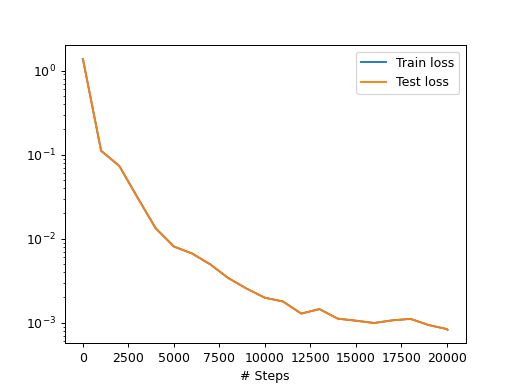

<IPython.core.display.Javascript object>


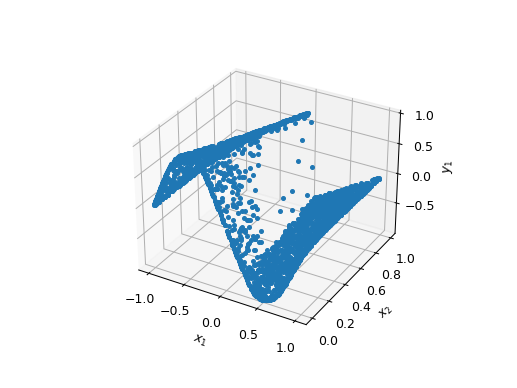

In [50]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname=loss_path, train_fname=train_path, test_fname=test_path)


# Load the Test Data

In [51]:
x_test, y_true, Nx, Nt = gen_testdata()
y_pred = model.predict(x_test)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test_burgers.dat", np.hstack((x_test, y_true, y_pred)))

L2 relative error: 0.2155619983531562


In [52]:
X_test, T_test = x_test[:,0], x_test[:,1]
X = X_test.reshape((Nt, Nx))
T = T_test.reshape((Nt, Nx))
Y_pred = y_pred.reshape((Nt, Nx))
Y_test = y_true.reshape((Nt, Nx))
x = X[0]
t = T[:,0]

<IPython.core.display.Javascript object>


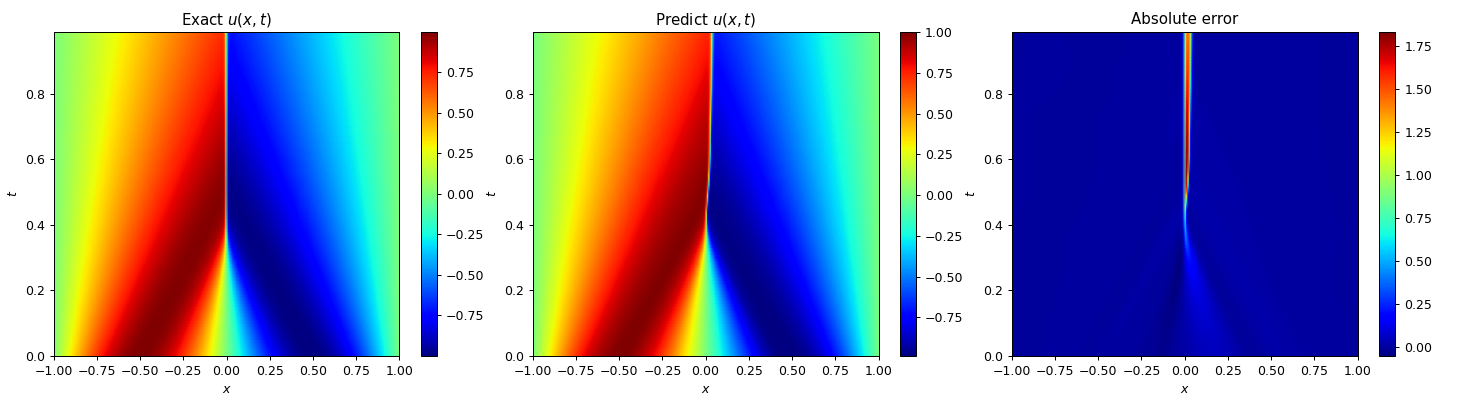

In [53]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, Y_pred - Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


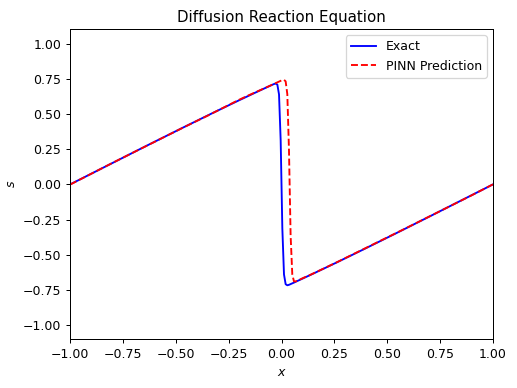

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, Y_test[0], 'b-', label='Exact')
ax.plot(x, Y_pred[0], 'r--', label='PINN Prediction')
ylim = plt.ylim()
xlim = [-1, 1]
plt.tight_layout()


for i in range(Nt):
    ax.clear()
    ax.plot(x, Y_test[i], 'b-', label='Exact')
    ax.plot(x, Y_pred[i], 'r--', label='PINN Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()

# Optionally Refine by Adding Additional Points Near Potential Shock (True Shock Occurs at Low to Zero Viscosity)

In [ ]:
save_dir = 'Burgers_RAR'
model_name = 'model_RAR'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, model_name)
ckpt_path = tf.train.latest_checkpoint(save_dir)
loss_fname = 'loss_Burgers_RAR.dat'
train_fname = 'train_Burgers_RAR.dat'
test_fname = 'test_Burgers_RAR.dat'
loss_path = os.path.join(save_dir, loss_fname)
train_path = os.path.join(save_dir, train_fname)
test_path = os.path.join(save_dir, test_fname)

# ckpt_path = os.path.join(save_dir, 'checkpoint')
# model.save(model_path)

In [55]:
model.restore(ckpt_path)

INFO:tensorflow:Restoring parameters from Burgers/model-15039.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

2 root error(s) found.
  (0) Not found: Key beta1_power_3 not found in checkpoint
	 [[node save_2/RestoreV2 (defined at /home/shawngr/.conda/envs/env/lib/python3.8/site-packages/deepxde/model.py:124) ]]
  (1) Not found: Key beta1_power_3 not found in checkpoint
	 [[node save_2/RestoreV2 (defined at /home/shawngr/.conda/envs/env/lib/python3.8/site-packages/deepxde/model.py:124) ]]
	 [[save_2/RestoreV2/_571]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'save_2/RestoreV2':
  File "/home/shawngr/.conda/envs/env/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/shawngr/.conda/envs/env/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shawngr/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/shawngr/.conda/envs/env/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/home/shawngr/.conda/envs/env/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/home/shawngr/.conda/envs/env/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
    self.do_execute(
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/shawngr/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2876, in run_cell
    result = self._run_cell(
  File "/home/shawngr/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2922, in _run_cell
    return runner(coro)
  File "/home/shawngr/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/shawngr/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3145, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/shawngr/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/shawngr/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-87a45cdf0d05>", line 1, in <module>
    model.compile("adam", lr=1e-3)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/deepxde/utils/internal.py", line 22, in wrapper
    result = f(*args, **kwargs)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/deepxde/model.py", line 107, in compile
    self._compile_tensorflow_compat_v1(lr, loss_fn, decay, loss_weights)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/deepxde/model.py", line 124, in _compile_tensorflow_compat_v1
    self.saver = tf.train.Saver(max_to_keep=None)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 836, in __init__
    self.build()
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 848, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 876, in _build
    self.saver_def = self._builder._build_internal(  # pylint: disable=protected-access
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 515, in _build_internal
    restore_op = self._AddRestoreOps(filename_tensor, saveables,
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 335, in _AddRestoreOps
    all_tensors = self.bulk_restore(filename_tensor, saveables, preferred_shard,
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 583, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1490, in restore_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3561, in _create_op_internal
    ret = Operation(
  File "/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


In [ ]:
X_reample = geomtime.random_points(100000)
err = 1
while err > 0.005:
    f = model.predict(X_reample, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X_reample[x_id], "\n")
    data.add_anchors(X_reample[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(
        epochs=10000, disregard_previous_best=True, callbacks=[early_stopping]
    )
    model.compile("L-BFGS-B")
    losshistory, train_state = model.train()

Mean residual: 3.832e-02
Adding new point: [0.01131582 0.4913069 ] 

Compiling model...
'compile' took 0.226008 s

Training model...

Step      Train loss                        Test loss                         Test metric
20040     [5.25e-01, 4.26e-07, 3.02e-04]    [5.19e-04, 4.26e-07, 3.02e-04]    []  
21000     [1.09e-03, 1.65e-06, 4.88e-04]    [1.08e-03, 1.65e-06, 4.88e-04]    []  
22000     [9.92e-04, 3.34e-06, 4.84e-04]    [9.89e-04, 3.34e-06, 4.84e-04]    []  
23000     [8.58e-04, 1.65e-06, 4.42e-04]    [8.46e-04, 1.65e-06, 4.42e-04]    []  
24000     [7.83e-04, 3.30e-06, 4.30e-04]    [7.81e-04, 3.30e-06, 4.30e-04]    []  
25000     [8.08e-04, 5.67e-06, 3.85e-04]    [8.06e-04, 5.67e-06, 3.85e-04]    []  
26000     [7.28e-04, 2.15e-06, 3.92e-04]    [7.24e-04, 2.15e-06, 3.92e-04]    []  
27000     [7.26e-04, 1.15e-06, 3.60e-04]    [7.23e-04, 1.15e-06, 3.60e-04]    []  
28000     [8.55e-04, 1.46e-05, 4.33e-04]    [8.55e-04, 1.46e-05, 4.33e-04]    []  
29000     [8.29e-04, 6.44e-06

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.001142
  Number of iterations: 11
  Number of functions evaluations: 65
57065     [4.00e-04, 9.77e-07, 7.41e-04]    [3.63e-04, 9.77e-07, 7.41e-04]    []  

Best model at step 57065:
  train loss: 1.14e-03
  test loss: 1.10e-03
  test metric: []

'train' took 1.261003 s

Mean residual: 1.210e-02
Adding new point: [0.02351809 0.6791663 ] 

Compiling model...
'compile' took 0.250907 s

Training model...

Step      Train loss                        Test loss                         Test metric
57065     [1.23e-03, 9.77e-07, 7.41e-04]    [3.63e-04, 9.77e-07, 7.41e-04]    []  
58000     [4.42e-04, 1.82e-06, 4.02e-04]    [4.35e-04, 1.82e-06, 4.02e-04]    []  
59000     [2.79e-04, 1.17e-06, 6.96e-05]    [2.77e-04, 1.17e-06, 6.96e-05]    []  
60000     [2.71e-04, 1.05e-06, 4.29e-05]    [2.70e-04, 1.05e-06, 4.29e-05]    []  
61000     [2.26e-04, 9.91e-07, 5.66e-0

76035     [1.63e-04, 1.02e-06, 1.38e-05]    [1.58e-04, 1.02e-06, 1.38e-05]    []  

Best model at step 76035:
  train loss: 1.78e-04
  test loss: 1.73e-04
  test metric: []

'train' took 2.082125 s

Mean residual: 8.191e-03
Adding new point: [0.00232935 0.46142116] 

Compiling model...
'compile' took 0.283551 s

Training model...

Step      Train loss                        Test loss                         Test metric
76035     [4.28e-04, 1.02e-06, 1.38e-05]    [1.58e-04, 1.02e-06, 1.38e-05]    []  
77000     [2.05e-04, 1.76e-06, 1.85e-05]    [1.69e-04, 1.76e-06, 1.85e-05]    []  
78000     [1.87e-04, 1.52e-06, 1.84e-05]    [1.59e-04, 1.52e-06, 1.84e-05]    []  
79000     [4.85e-04, 5.41e-06, 2.70e-05]    [2.58e-04, 5.41e-06, 2.70e-05]    []  
Epoch 79000: early stopping

Best model at step 78000:
  train loss: 2.07e-04
  test loss: 1.79e-04
  test metric: []

'train' took 7.085053 s

Compiling model...
'compile' took 0.216493 s

Training model...

Step      Train loss                

91222     [2.14e-04, 7.63e-07, 4.12e-05]    [1.31e-04, 7.63e-07, 4.12e-05]    []  
92000     [2.56e-04, 3.89e-06, 5.01e-05]    [1.74e-04, 3.89e-06, 5.01e-05]    []  
93000     [1.68e-04, 7.32e-07, 5.33e-05]    [1.32e-04, 7.32e-07, 5.33e-05]    []  
Epoch 93223: early stopping

Best model at step 93000:
  train loss: 2.22e-04
  test loss: 1.86e-04
  test metric: []

'train' took 6.453737 s

Compiling model...
'compile' took 0.252836 s

Training model...

Step      Train loss                        Test loss                         Test metric
93223     [2.37e-04, 4.64e-06, 5.33e-05]    [1.56e-04, 4.64e-06, 5.33e-05]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000214
  Number of iterations: 10
  Number of functions evaluations: 46
93269     [1.62e-04, 7.64e-07, 5.19e-05]    [1.27e-04, 7.64e-07, 5.19e-05]    []  

Best model at step 93269:
  train loss: 2.14e-04
  test loss: 1.79e-04
  test 

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000191
  Number of iterations: 10
  Number of functions evaluations: 41
105526    [1.62e-04, 1.16e-06, 2.75e-05]    [1.36e-04, 1.16e-06, 2.75e-05]    []  

Best model at step 105526:
  train loss: 1.91e-04
  test loss: 1.64e-04
  test metric: []

'train' took 4.417670 s

Mean residual: 6.902e-03
Adding new point: [-0.00844812  0.31546435] 

Compiling model...
'compile' took 0.365414 s

Training model...

Step      Train loss                        Test loss                         Test metric
105526    [1.73e-04, 1.16e-06, 2.75e-05]    [1.36e-04, 1.16e-06, 2.75e-05]    []  
106000    [1.69e-04, 4.69e-07, 2.98e-05]    [1.38e-04, 4.69e-07, 2.98e-05]    []  
107000    [1.79e-04, 5.65e-07, 3.04e-05]    [1.43e-04, 5.65e-07, 3.04e-05]    []  
Epoch 107527: early stopping

Best model at step 106000:
  train loss: 1.99e-04
  test loss: 1.68e-04
  test metric: [

117860    [1.59e-04, 1.62e-06, 2.97e-05]    [1.20e-04, 1.62e-06, 2.97e-05]    []  
118000    [1.70e-04, 3.57e-07, 3.06e-05]    [1.27e-04, 3.57e-07, 3.06e-05]    []  
119000    [4.56e-04, 5.28e-06, 3.11e-05]    [2.59e-04, 5.28e-06, 3.11e-05]    []  
Epoch 119861: early stopping

Best model at step 117860:
  train loss: 1.90e-04
  test loss: 1.51e-04
  test metric: []

'train' took 8.636590 s

Compiling model...
'compile' took 0.334907 s

Training model...

Step      Train loss                        Test loss                         Test metric
119861    [2.89e-04, 8.58e-07, 2.99e-05]    [1.69e-04, 8.58e-07, 2.99e-05]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000187
  Number of iterations: 6
  Number of functions evaluations: 35
119896    [1.55e-04, 9.81e-07, 3.08e-05]    [1.16e-04, 9.81e-07, 3.08e-05]    []  

Best model at step 119896:
  train loss: 1.87e-04
  test loss: 1.48e-04
  tes

132140    [3.62e-04, 5.63e-06, 3.87e-05]    [1.56e-04, 5.63e-06, 3.87e-05]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000175
  Number of iterations: 10
  Number of functions evaluations: 52
132192    [1.44e-04, 8.91e-07, 2.96e-05]    [1.05e-04, 8.91e-07, 2.96e-05]    []  

Best model at step 132192:
  train loss: 1.75e-04
  test loss: 1.35e-04
  test metric: []

'train' took 7.354664 s

Mean residual: 6.150e-03
Adding new point: [0.0038743 0.3597451] 

Compiling model...
'compile' took 0.452888 s

Training model...

Step      Train loss                        Test loss                         Test metric
132192    [1.53e-04, 8.91e-07, 2.96e-05]    [1.05e-04, 8.91e-07, 2.96e-05]    []  
133000    [2.17e-04, 1.53e-06, 3.03e-05]    [1.25e-04, 1.53e-06, 3.03e-05]    []  
134000    [7.49e-04, 5.88e-06, 3.66e-05]    [2.98e-04, 5.88e-06, 3.66e-05]    []  
Epoch 134193: early stopping

Best mode

Training model...

Step      Train loss                        Test loss                         Test metric
144411    [1.33e-04, 3.54e-07, 2.86e-05]    [9.74e-05, 3.54e-07, 2.86e-05]    []  
145000    [1.32e-04, 5.20e-07, 2.92e-05]    [9.62e-05, 5.20e-07, 2.92e-05]    []  
146000    [2.96e-04, 1.53e-06, 2.61e-05]    [1.49e-04, 1.53e-06, 2.61e-05]    []  
Epoch 146412: early stopping

Best model at step 144411:
  train loss: 1.61e-04
  test loss: 1.26e-04
  test metric: []

'train' took 11.366066 s

Compiling model...
'compile' took 0.416667 s

Training model...

Step      Train loss                        Test loss                         Test metric
146412    [1.79e-04, 5.43e-06, 3.22e-05]    [1.13e-04, 5.43e-06, 3.22e-05]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000152
  Number of iterations: 9
  Number of functions evaluations: 32
146444    [1.22e-04, 9.52e-07, 2.83e-05]    [9.34e-

158649    [2.16e-04, 3.03e-06, 2.57e-05]    [1.42e-04, 3.03e-06, 2.57e-05]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000154
  Number of iterations: 4
  Number of functions evaluations: 31
158680    [1.27e-04, 3.63e-06, 2.34e-05]    [8.93e-05, 3.63e-06, 2.34e-05]    []  

Best model at step 156648:
  train loss: 1.48e-04
  test loss: 1.11e-04
  test metric: []

'train' took 10.915704 s

Mean residual: 5.617e-03
Adding new point: [-4.2915344e-05  3.5052902e-01] 

Compiling model...
'compile' took 0.552337 s

Training model...

Step      Train loss                        Test loss                         Test metric
158680    [1.29e-04, 3.63e-06, 2.34e-05]    [8.93e-05, 3.63e-06, 2.34e-05]    []  
159000    [1.22e-04, 3.42e-07, 2.45e-05]    [8.31e-05, 3.42e-07, 2.45e-05]    []  
160000    [1.76e-04, 9.57e-07, 2.42e-05]    [1.17e-04, 9.57e-07, 2.42e-05]    []  
Epoch 160681: early stopping


Training model...

Step      Train loss                        Test loss                         Test metric
170969    [1.19e-04, 1.31e-06, 2.17e-05]    [8.20e-05, 1.31e-06, 2.17e-05]    []  
171000    [5.68e-04, 1.26e-04, 7.05e-05]    [2.47e-04, 1.26e-04, 7.05e-05]    []  
172000    [1.95e-04, 5.97e-07, 2.10e-05]    [8.02e-05, 5.97e-07, 2.10e-05]    []  
Epoch 172970: early stopping

Best model at step 170969:
  train loss: 1.42e-04
  test loss: 1.05e-04
  test metric: []

'train' took 15.028612 s

Compiling model...
'compile' took 0.514556 s

Training model...

Step      Train loss                        Test loss                         Test metric
172970    [4.14e-04, 2.27e-06, 2.00e-05]    [1.34e-04, 2.27e-06, 2.00e-05]    []  
173000    [1.10e-04, 9.27e-07, 2.05e-05]                                          
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000132
  Number of iterations: 12
  Num

'compile' took 0.551664 s

Training model...

Step      Train loss                        Test loss                         Test metric
185245    [3.47e-04, 2.05e-06, 2.60e-05]    [1.65e-04, 2.05e-06, 2.60e-05]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000133
  Number of iterations: 8
  Number of functions evaluations: 49
185294    [1.11e-04, 8.68e-07, 2.08e-05]    [7.32e-05, 8.68e-07, 2.08e-05]    []  

Best model at step 183244:
  train loss: 1.26e-04
  test loss: 9.42e-05
  test metric: []

'train' took 15.075295 s

Mean residual: 5.271e-03
Adding new point: [0.00676012 0.5833262 ] 

Compiling model...
'compile' took 0.628426 s

Training model...

Step      Train loss                        Test loss                         Test metric
185294    [1.13e-04, 8.68e-07, 2.08e-05]    [7.32e-05, 8.68e-07, 2.08e-05]    []  
186000    [1.12e-04, 3.88e-07, 2.10e-05]    [7.42e-05, 3.88e-07, 2.

In [ ]:
model.save(save_dir)

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname=loss_path, train_fname=train_path, test_fname=test_path)


# Load the Test Data

In [ ]:
x_test, y_true, Nx, Nt = gen_testdata()
y_pred = model.predict(x_test)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test_burgers.dat", np.hstack((x_test, y_true, y_pred)))

In [21]:
X_test, T_test = x_test[:,0], x_test[:,1]
X = X_test.reshape((Nt, Nx))
T = T_test.reshape((Nt, Nx))
Y_pred = y_pred.reshape((Nt, Nx))
Y_test = y_true.reshape((Nt, Nx))

<IPython.core.display.Javascript object>


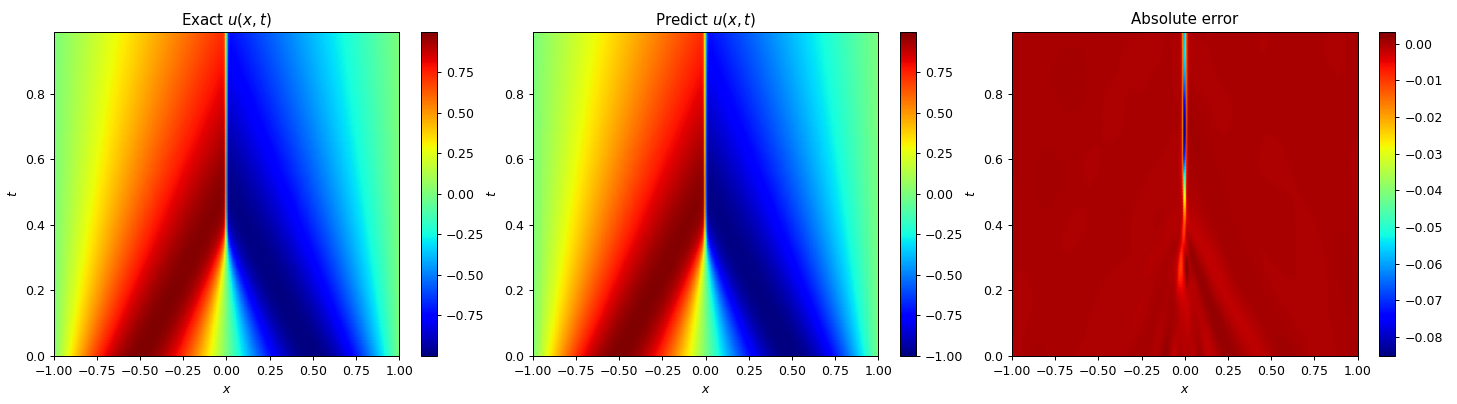

In [22]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, Y_pred - Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


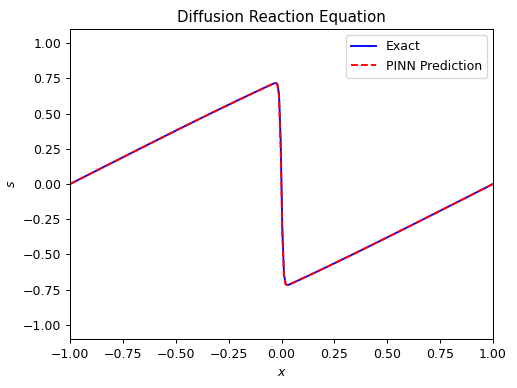

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, Y_test[0], 'b-', label='Exact')
ax.plot(x, Y_pred[0], 'r--', label='PINN Prediction')
ylim = plt.ylim()
xlim = [-1, 1]
plt.tight_layout()


for i in range(Nt):
    ax.clear()
    ax.plot(x, Y_test[i], 'b-', label='Exact')
    ax.plot(x, Y_pred[i], 'r--', label='PINN Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()